In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)



Libraries imported successfully!
TensorFlow version: 2.15.0


In [3]:
df = pd.read_csv(r"Z:\ai lab\bank-full.csv", sep=';')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nMissing values before preprocessing:\n{df.isnull().sum()}")

# Handle missing values (replace 'unknown' with NaN and forward fill)
df.replace("unknown", np.nan, inplace=True)
df.ffill(inplace=True)

# Encode target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

print(f"\nTarget distribution:\n{df['y'].value_counts()}")

# Separate features and target
X = df.drop('y', axis=1)
y = df['y']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

print(f"\nFeature shape after encoding: {X.shape}")
print(f"Number of features: {X.shape[1]}")

Dataset shape: (45211, 17)

First few rows:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Missing values before preprocessing:
age          0
job          0

In [4]:
# Split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split temp: 50% validation, 50% test (15% each of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

Training set size: 31647 (70.0%)
Validation set size: 6782 (15.0%)
Test set size: 6782 (15.0%)


In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Features standardized successfully!")
print(f"Training data shape: {X_train.shape}")
print(f"Feature means (should be ~0): {X_train.mean(axis=0)[:5]}")
print(f"Feature stds (should be ~1): {X_train.std(axis=0)[:5]}")

Features standardized successfully!
Training data shape: (31647, 38)
Feature means (should be ~0): [4.26590577e-17 4.49042712e-19 7.63372611e-17 7.49901329e-17
 6.75809282e-17]
Feature stds (should be ~1): [1. 1. 1. 1. 1.]


In [6]:
def build_model(input_dim, optimizer):
    """
    Build neural network with fixed architecture:
    - Input layer (input_dim)
    - Dense(128, ReLU) -> Dropout(0.3)
    - Dense(64, ReLU) -> Dropout(0.2)
    - Dense(1, Sigmoid)
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Model building function defined!")


Model building function defined!


In [7]:
optimizers = {
    "Batch GD": SGD(learning_rate=0.01),
    "SGD": SGD(learning_rate=0.01),
    "Mini-Batch": SGD(learning_rate=0.01),
    "Momentum": SGD(learning_rate=0.01, momentum=0.9),
    "Nesterov": SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
}

# Define batch sizes for each optimizer
batch_sizes = {
    "Batch GD": len(X_train),      # Full batch
    "SGD": 1,                       # Single sample
    "Mini-Batch": 32,               # Mini-batch
    "Momentum": 32,                 # Mini-batch with momentum
    "Nesterov": 32                  # Mini-batch with Nesterov
}

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Storage for results
histories = {}
times = {}
models = {}

# Train each optimizer
for name, optimizer in optimizers.items():
    print(f"\n{'='*60}")
    print(f"Training with {name}")
    print(f"Batch size: {batch_sizes[name]}")
    print(f"{'='*60}")
    
    model = build_model(X_train.shape[1], optimizer)
    
    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=batch_sizes[name],
        callbacks=[early_stop],
        verbose=1
    )
    end = time.time()
    
    histories[name] = history
    times[name] = end - start
    models[name] = model
    
    print(f"\nTraining completed in {times[name]:.2f} seconds")
    print(f"Total epochs: {len(history.history['loss'])}")

print("\n" + "="*60)
print("All optimizers trained successfully!")
print("="*60)


Training with Batch GD
Batch size: 31647

Epoch 1/200


1/1 [==============================] - 1s 706ms/step - loss: 0.9729 - accuracy: 0.2540 - val_loss: 0.8738 - val_accuracy: 0.2204
Epoch 2/200
1/1 [==============================] - 0s 64ms/step - loss: 0.9417 - accuracy: 0.2778 - val_loss: 0.8422 - val_accuracy: 0.2560
Epoch 3/200
1/1 [==============================] - 0s 83ms/step - loss: 0.9049 - accuracy: 0.3037 - val_loss: 0.8131 - val_accuracy: 0.2952
Epoch 4/200
1/1 [==============================] - 0s 66ms/step - loss: 0.8737 - accuracy: 0.3340 - val_loss: 0.7861 - val_accuracy: 0.3390
Epoch 5/200
1/1 [==============================] - 0s 67ms/step - loss: 0.8464 - accuracy: 0.3648 - val_loss: 0.7612 - val_accuracy: 0.3803
Epoch 6/200
1/1 [==============================] - 0s 79ms/step - loss: 0.8181 - accuracy: 0.3935 - val_loss: 0.7381 - val_accuracy: 0.4326
Epoch 7/200
1/1 [==============================] - 0s 64ms/step - loss: 0.7954 - accuracy: 0.4199 - val_loss: 0.71

In [8]:
print("\nTraining Time Comparison:")
print("-" * 50)
for name, t in times.items():
    print(f"{name:15s}: {t:8.2f} seconds")
print("-" * 50)



Training Time Comparison:
--------------------------------------------------
Batch GD       :    14.81 seconds
SGD            :   599.55 seconds
Mini-Batch     :   119.68 seconds
Momentum       :    52.33 seconds
Nesterov       :    52.37 seconds
--------------------------------------------------


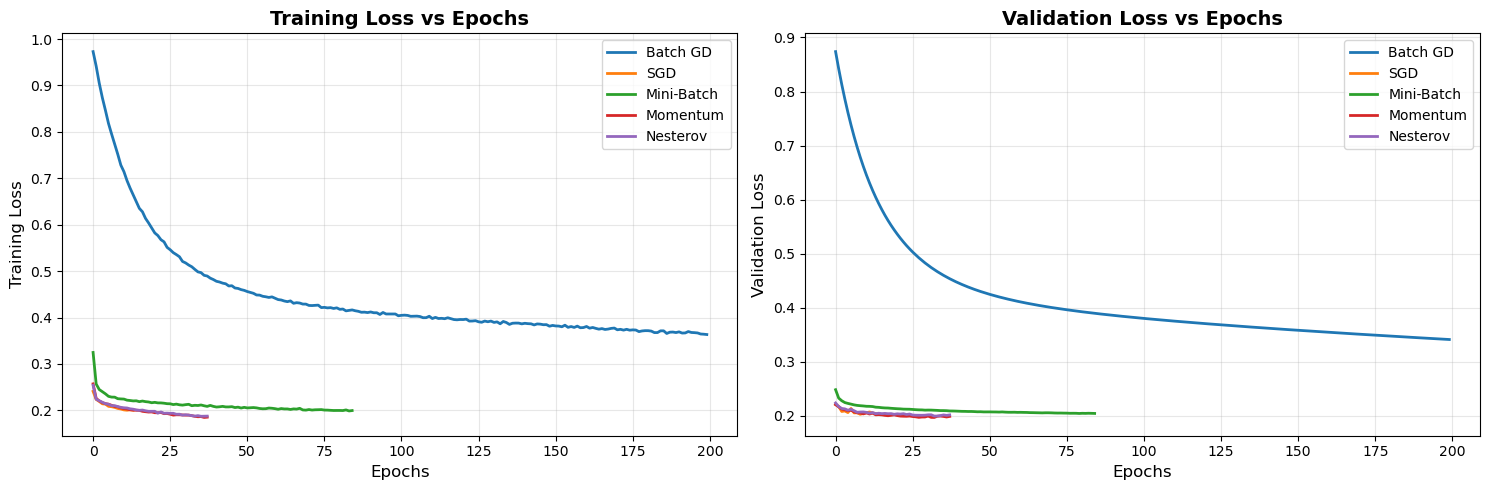

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss
for name, history in histories.items():
    axes[0].plot(history.history['loss'], label=name, linewidth=2)

axes[0].set_xlabel("Epochs", fontsize=12)
axes[0].set_ylabel("Training Loss", fontsize=12)
axes[0].set_title("Training Loss vs Epochs", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Loss
for name, history in histories.items():
    axes[1].plot(history.history['val_loss'], label=name, linewidth=2)

axes[1].set_xlabel("Epochs", fontsize=12)
axes[1].set_ylabel("Validation Loss", fontsize=12)
axes[1].set_title("Validation Loss vs Epochs", fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



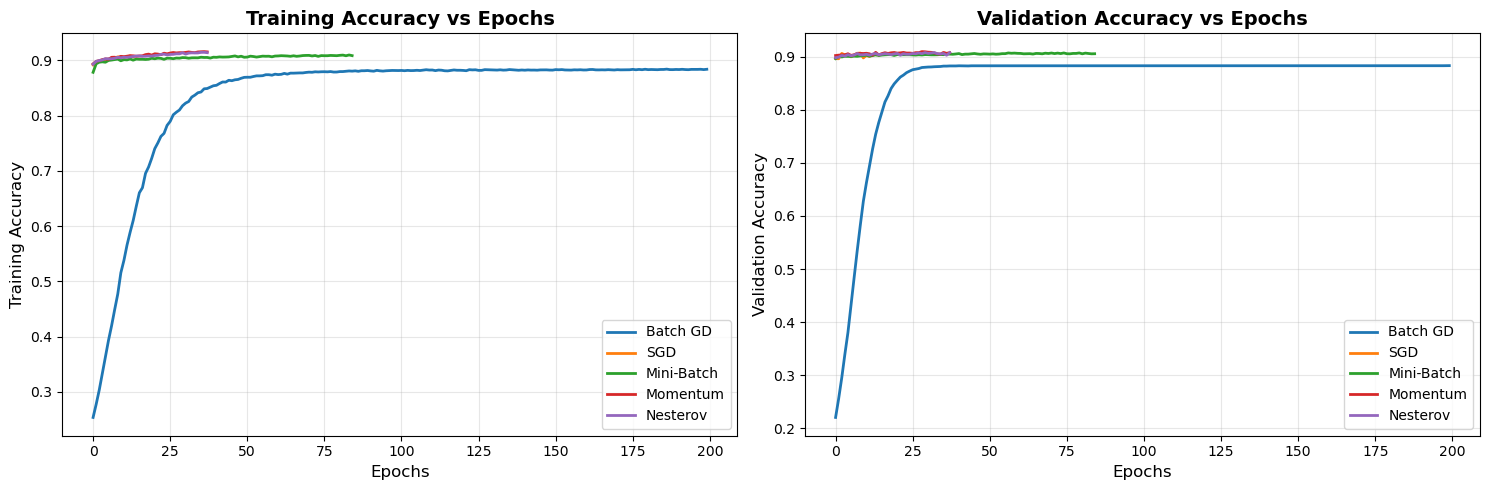

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Accuracy
for name, history in histories.items():
    axes[0].plot(history.history['accuracy'], label=name, linewidth=2)

axes[0].set_xlabel("Epochs", fontsize=12)
axes[0].set_ylabel("Training Accuracy", fontsize=12)
axes[0].set_title("Training Accuracy vs Epochs", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Accuracy
for name, history in histories.items():
    axes[1].plot(history.history['val_accuracy'], label=name, linewidth=2)

axes[1].set_xlabel("Epochs", fontsize=12)
axes[1].set_ylabel("Validation Accuracy", fontsize=12)
axes[1].set_title("Validation Accuracy vs Epochs", fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Analyzing Effect of Mini-Batch Size

Training with batch size 16...
Epoch 1/200
1978/1978 [==============================] - 3s 1ms/step - loss: 0.3002 - accuracy: 0.8863 - val_loss: 0.2369 - val_accuracy: 0.8993
Epoch 2/200
1978/1978 [==============================] - 2s 1ms/step - loss: 0.2461 - accuracy: 0.8962 - val_loss: 0.2266 - val_accuracy: 0.9017
Epoch 3/200
1978/1978 [==============================] - 3s 1ms/step - loss: 0.2359 - accuracy: 0.8969 - val_loss: 0.2228 - val_accuracy: 0.9030
Epoch 4/200
1978/1978 [==============================] - 3s 1ms/step - loss: 0.2322 - accuracy: 0.8984 - val_loss: 0.2212 - val_accuracy: 0.9028
Epoch 5/200
1978/1978 [==============================] - 3s 1ms/step - loss: 0.2275 - accuracy: 0.8996 - val_loss: 0.2196 - val_accuracy: 0.9027
Epoch 6/200
1978/1978 [==============================] - 2s 1ms/step - loss: 0.2254 - accuracy: 0.9008 - val_loss: 0.2192 - val_accuracy: 0.9018
Epoch 7/200
1978/1978 [==============================] - 3s 1

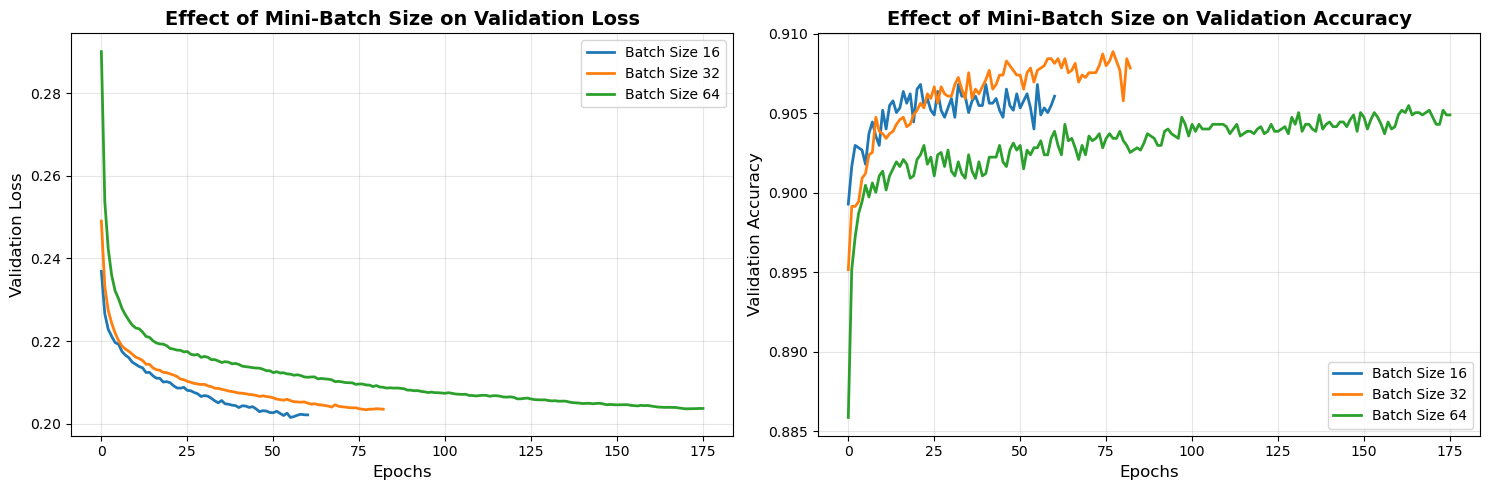

In [12]:
print("\n" + "="*60)
print("Analyzing Effect of Mini-Batch Size")
print("="*60)

batch_sizes_test = [16, 32, 64]
batch_histories = {}

for bs in batch_sizes_test:
    print(f"\nTraining with batch size {bs}...")
    
    optimizer = SGD(learning_rate=0.01)
    model = build_model(X_train.shape[1], optimizer)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=bs,
        callbacks=[early_stop],
        verbose=1
    )
    
    batch_histories[bs] = history
    print(f"Completed in {len(history.history['loss'])} epochs")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Validation Loss
for bs, history in batch_histories.items():
    axes[0].plot(history.history['val_loss'], label=f"Batch Size {bs}", linewidth=2)

axes[0].set_xlabel("Epochs", fontsize=12)
axes[0].set_ylabel("Validation Loss", fontsize=12)
axes[0].set_title("Effect of Mini-Batch Size on Validation Loss", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Accuracy
for bs, history in batch_histories.items():
    axes[1].plot(history.history['val_accuracy'], label=f"Batch Size {bs}", linewidth=2)

axes[1].set_xlabel("Epochs", fontsize=12)
axes[1].set_ylabel("Validation Accuracy", fontsize=12)
axes[1].set_title("Effect of Mini-Batch Size on Validation Accuracy", fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Hyperparameter Sensitivity Analysis: Learning Rate (SGD)

Training SGD with learning rate 0.001...
Epoch 1/200
31647/31647 [==============================] - 41s 1ms/step - loss: 0.2773 - accuracy: 0.8893 - val_loss: 0.2257 - val_accuracy: 0.9017
Epoch 2/200
31647/31647 [==============================] - 41s 1ms/step - loss: 0.2361 - accuracy: 0.8963 - val_loss: 0.2196 - val_accuracy: 0.9009
Epoch 3/200
31647/31647 [==============================] - 44s 1ms/step - loss: 0.2296 - accuracy: 0.8988 - val_loss: 0.2171 - val_accuracy: 0.9015
Epoch 4/200
31647/31647 [==============================] - 42s 1ms/step - loss: 0.2233 - accuracy: 0.9014 - val_loss: 0.2155 - val_accuracy: 0.9014
Epoch 5/200
31647/31647 [==============================] - 35s 1ms/step - loss: 0.2240 - accuracy: 0.9008 - val_loss: 0.2143 - val_accuracy: 0.9015
Epoch 6/200
31647/31647 [==============================] - 33s 1ms/step - loss: 0.2205 - accuracy: 0.9012 - val_loss: 0.2148 - val_accuracy: 0.9045
Epoch 7/200


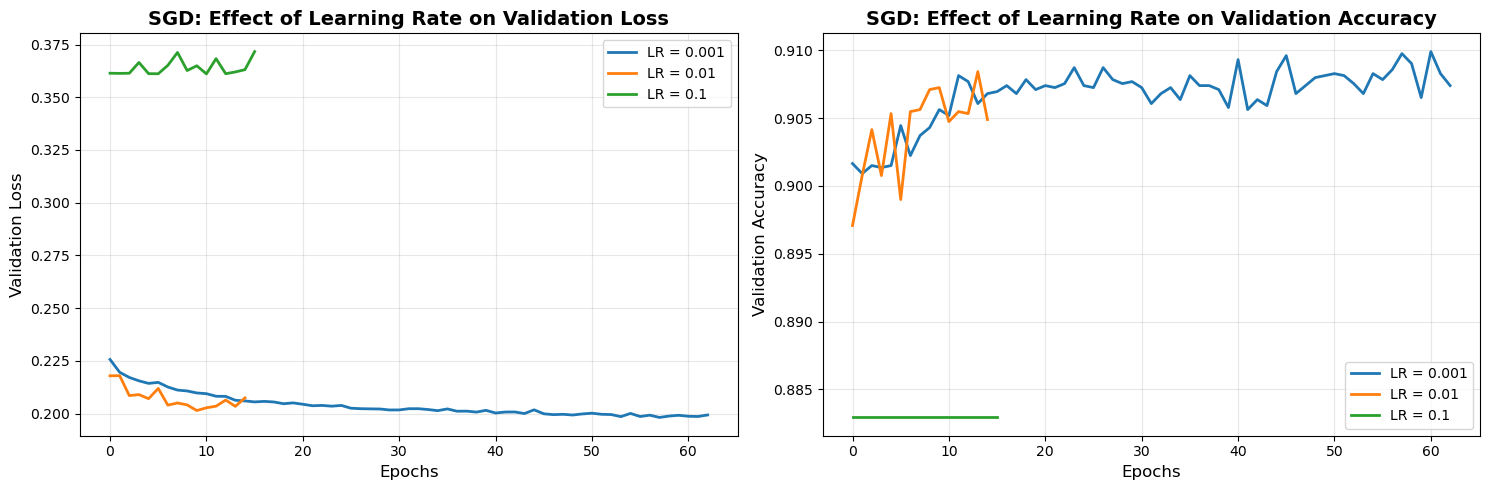

In [13]:
print("\n" + "="*60)
print("Hyperparameter Sensitivity Analysis: Learning Rate (SGD)")
print("="*60)

learning_rates = [0.001, 0.01, 0.1]
lr_histories = {}

for lr in learning_rates:
    print(f"\nTraining SGD with learning rate {lr}...")
    
    optimizer = SGD(learning_rate=lr)
    model = build_model(X_train.shape[1], optimizer)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=1,
        callbacks=[early_stop],
        verbose=1
    )
    
    lr_histories[lr] = history
    print(f"Completed in {len(history.history['loss'])} epochs")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Validation Loss
for lr, history in lr_histories.items():
    axes[0].plot(history.history['val_loss'], label=f"LR = {lr}", linewidth=2)

axes[0].set_xlabel("Epochs", fontsize=12)
axes[0].set_ylabel("Validation Loss", fontsize=12)
axes[0].set_title("SGD: Effect of Learning Rate on Validation Loss", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Accuracy
for lr, history in lr_histories.items():
    axes[1].plot(history.history['val_accuracy'], label=f"LR = {lr}", linewidth=2)

axes[1].set_xlabel("Epochs", fontsize=12)
axes[1].set_ylabel("Validation Accuracy", fontsize=12)
axes[1].set_title("SGD: Effect of Learning Rate on Validation Accuracy", fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Hyperparameter Sensitivity Analysis: Momentum Coefficient

Testing Momentum optimizer...
Training with momentum = 0.5...
Epoch 1/200
989/989 [==============================] - 2s 2ms/step - loss: 0.2948 - accuracy: 0.8853 - val_loss: 0.2353 - val_accuracy: 0.8981
Epoch 2/200
989/989 [==============================] - 1s 1ms/step - loss: 0.2439 - accuracy: 0.8970 - val_loss: 0.2260 - val_accuracy: 0.9008
Epoch 3/200
989/989 [==============================] - 1s 1ms/step - loss: 0.2350 - accuracy: 0.8978 - val_loss: 0.2223 - val_accuracy: 0.9019
Epoch 4/200
989/989 [==============================] - 1s 1ms/step - loss: 0.2292 - accuracy: 0.8996 - val_loss: 0.2201 - val_accuracy: 0.9015
Epoch 5/200
989/989 [==============================] - 1s 1ms/step - loss: 0.2268 - accuracy: 0.9006 - val_loss: 0.2185 - val_accuracy: 0.9006
Epoch 6/200
989/989 [==============================] - 1s 1ms/step - loss: 0.2234 - accuracy: 0.9018 - val_loss: 0.2178 - val_accuracy: 0.9015
Epoch 7/200
989/989 

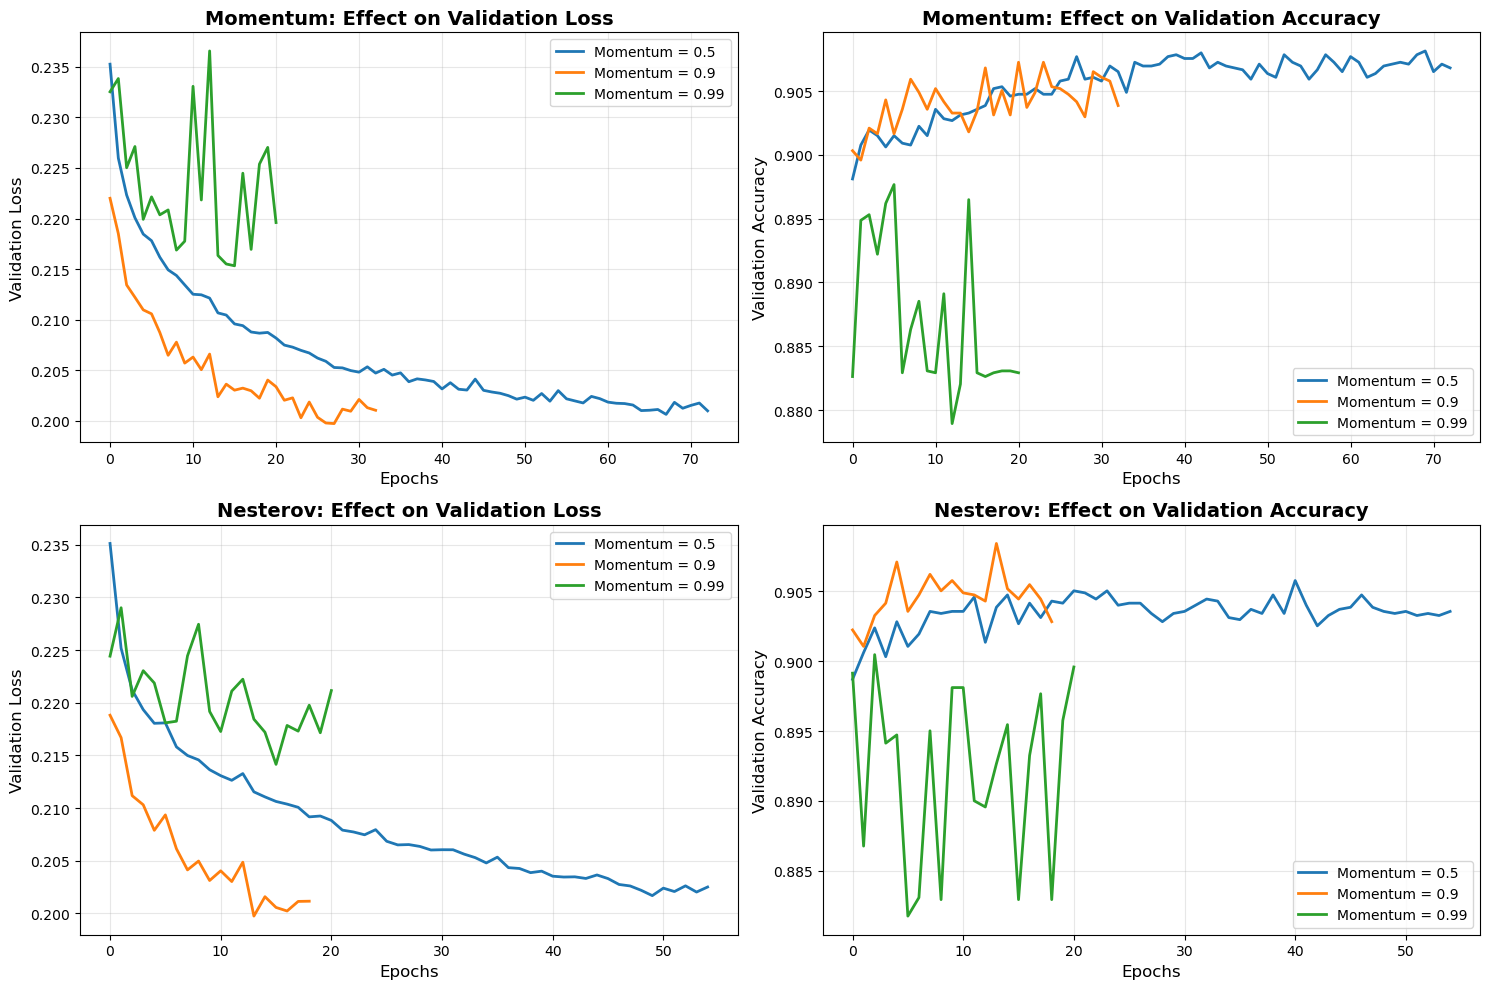

In [14]:
print("\n" + "="*60)
print("Hyperparameter Sensitivity Analysis: Momentum Coefficient")
print("="*60)

momentum_values = [0.5, 0.9, 0.99]
momentum_histories = {}
nesterov_histories = {}

# Test Momentum
print("\nTesting Momentum optimizer...")
for mom in momentum_values:
    print(f"Training with momentum = {mom}...")
    
    optimizer = SGD(learning_rate=0.01, momentum=mom)
    model = build_model(X_train.shape[1], optimizer)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    
    momentum_histories[mom] = history
    print(f"Completed in {len(history.history['loss'])} epochs")

# Test Nesterov Momentum
print("\nTesting Nesterov optimizer...")
for mom in momentum_values:
    print(f"Training with momentum = {mom} (Nesterov)...")
    
    optimizer = SGD(learning_rate=0.01, momentum=mom, nesterov=True)
    model = build_model(X_train.shape[1], optimizer)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    
    nesterov_histories[mom] = history
    print(f"Completed in {len(history.history['loss'])} epochs")

# Plot Momentum results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Momentum - Validation Loss
for mom, history in momentum_histories.items():
    axes[0, 0].plot(history.history['val_loss'], label=f"Momentum = {mom}", linewidth=2)
axes[0, 0].set_xlabel("Epochs", fontsize=12)
axes[0, 0].set_ylabel("Validation Loss", fontsize=12)
axes[0, 0].set_title("Momentum: Effect on Validation Loss", fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Momentum - Validation Accuracy
for mom, history in momentum_histories.items():
    axes[0, 1].plot(history.history['val_accuracy'], label=f"Momentum = {mom}", linewidth=2)
axes[0, 1].set_xlabel("Epochs", fontsize=12)
axes[0, 1].set_ylabel("Validation Accuracy", fontsize=12)
axes[0, 1].set_title("Momentum: Effect on Validation Accuracy", fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Nesterov - Validation Loss
for mom, history in nesterov_histories.items():
    axes[1, 0].plot(history.history['val_loss'], label=f"Momentum = {mom}", linewidth=2)
axes[1, 0].set_xlabel("Epochs", fontsize=12)
axes[1, 0].set_ylabel("Validation Loss", fontsize=12)
axes[1, 0].set_title("Nesterov: Effect on Validation Loss", fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Nesterov - Validation Accuracy
for mom, history in nesterov_histories.items():
    axes[1, 1].plot(history.history['val_accuracy'], label=f"Momentum = {mom}", linewidth=2)
axes[1, 1].set_xlabel("Epochs", fontsize=12)
axes[1, 1].set_ylabel("Validation Accuracy", fontsize=12)
axes[1, 1].set_title("Nesterov: Effect on Validation Accuracy", fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
print("\n" + "="*60)
print("Selecting Best Optimizer")
print("="*60)

# Evaluate final validation accuracy for each optimizer
val_accuracies = {}
for name, history in histories.items():
    final_val_acc = history.history['val_accuracy'][-1]
    val_accuracies[name] = final_val_acc
    print(f"{name:15s}: Final Validation Accuracy = {final_val_acc:.4f}")

# Find best optimizer
best_optimizer_name = max(val_accuracies, key=val_accuracies.get)
best_model = models[best_optimizer_name]

print(f"\n{'='*60}")
print(f"Best Optimizer: {best_optimizer_name}")
print(f"Best Validation Accuracy: {val_accuracies[best_optimizer_name]:.4f}")
print(f"{'='*60}")


Selecting Best Optimizer
Batch GD       : Final Validation Accuracy = 0.8832
SGD            : Final Validation Accuracy = 0.9037
Mini-Batch     : Final Validation Accuracy = 0.9056
Momentum       : Final Validation Accuracy = 0.9077
Nesterov       : Final Validation Accuracy = 0.9077

Best Optimizer: Momentum
Best Validation Accuracy: 0.9077


In [16]:
print("\n" + "="*60)
print(f"Evaluating {best_optimizer_name} on Test Set")
print("="*60)

# Predict on test set
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"-" * 40)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"\nConfusion Matrix:")
print(cm)



Evaluating Momentum on Test Set
212/212 [==============================] - 0s 2ms/step

Test Set Performance:
----------------------------------------
Accuracy:  0.9034
Precision: 0.6259
Recall:    0.4325
F1-Score:  0.5116

Confusion Matrix:
[[5784  205]
 [ 450  343]]


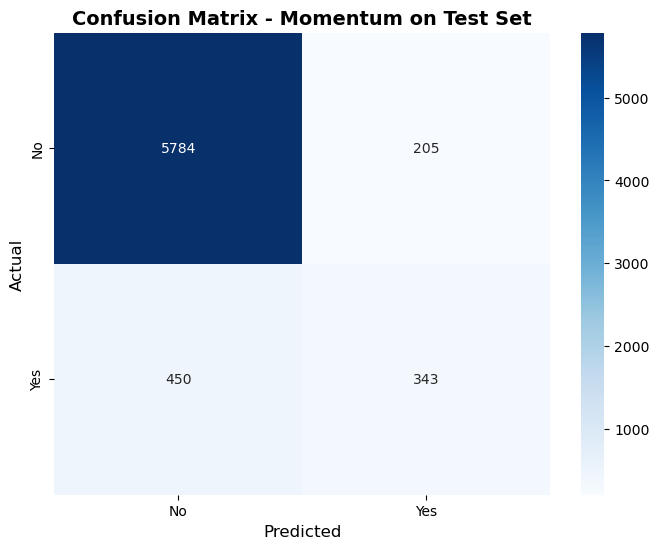

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Confusion Matrix - {best_optimizer_name} on Test Set', 
          fontsize=14, fontweight='bold')
plt.show()

In [18]:
print("\n" + "="*70)
print("COMPARATIVE ANALYSIS SUMMARY")
print("="*70)

print("\n1. CONVERGENCE SPEED:")
print("-" * 70)
epochs_taken = {name: len(hist.history['loss']) for name, hist in histories.items()}
for name, epochs in sorted(epochs_taken.items(), key=lambda x: x[1]):
    print(f"   {name:15s}: {epochs:3d} epochs, {times[name]:8.2f} seconds")

print("\n2. OSCILLATION BEHAVIOR (std of last 10 epochs validation loss):")
print("-" * 70)
oscillations = {}
for name, hist in histories.items():
    last_10_val_loss = hist.history['val_loss'][-10:]
    oscillations[name] = np.std(last_10_val_loss)
    print(f"   {name:15s}: {oscillations[name]:.6f}")

print("\n3. STABILITY (final validation accuracy):")
print("-" * 70)
for name, acc in sorted(val_accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"   {name:15s}: {acc:.4f}")

print("\n4. COMPUTATIONAL EFFICIENCY (time per epoch):")
print("-" * 70)
time_per_epoch = {name: times[name]/epochs_taken[name] for name in times.keys()}
for name, tpe in sorted(time_per_epoch.items(), key=lambda x: x[1]):
    print(f"   {name:15s}: {tpe:.2f} seconds/epoch")

print("\n5. TEST SET GENERALIZATION:")
print("-" * 70)
print(f"   Best Optimizer: {best_optimizer_name}")
print(f"   Test Accuracy:  {accuracy:.4f}")
print(f"   Test F1-Score:  {f1:.4f}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)


COMPARATIVE ANALYSIS SUMMARY

1. CONVERGENCE SPEED:
----------------------------------------------------------------------
   SGD            :  14 epochs,   599.55 seconds
   Momentum       :  38 epochs,    52.33 seconds
   Nesterov       :  38 epochs,    52.37 seconds
   Mini-Batch     :  85 epochs,   119.68 seconds
   Batch GD       : 200 epochs,    14.81 seconds

2. OSCILLATION BEHAVIOR (std of last 10 epochs validation loss):
----------------------------------------------------------------------
   Batch GD       : 0.000934
   SGD            : 0.002751
   Mini-Batch     : 0.000166
   Momentum       : 0.000901
   Nesterov       : 0.000820

3. STABILITY (final validation accuracy):
----------------------------------------------------------------------
   Momentum       : 0.9077
   Nesterov       : 0.9077
   Mini-Batch     : 0.9056
   SGD            : 0.9037
   Batch GD       : 0.8832

4. COMPUTATIONAL EFFICIENCY (time per epoch):
-----------------------------------------------------